# COVID-19, Pneumonia and normal lung X-Ray Classification

### This notebook contains model to classify X-ray lung images of Covid-19, Viral Pneumonia patients and normal person using Resnets in pytorch.
Covid19-image-dataset is an image dataset in Kaggle used for classification into Covid-19, Viral Pneumonia and normal X-ray images.

In [ ]:
#Import required libraries
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
#look into data directiory
data_dir = 'Covid19-dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test']
['Viral Pneumonia', 'Covid', 'Normal']


## Preparing the Dataset

This dataset is divided into two folders 'train' and 'test' set, which are further divided into three classes 'Viral Pneumonia', 'Covid' and 'Normal'.

We'll make few changes while creating PyTorch datasets for training and validation:
1. **We'll simply use the test set as our validation set. This just gives a little more data to train with.**
2. **We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel.** - Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<center> <img src="https://i.imgur.com/LYxXBVg.png" width="360"> </center>

In [ ]:
# Data transform(normalization and resizing)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
size = (256, 256)
train_tfms =  tt.Compose([tt.Resize(size, interpolation=2),
                          tt.ToTensor(),
                          tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize(size, interpolation=2),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
len(train_ds), len(valid_ds)

(251, 66)

There 251 train images and 66 validation images

We will select the batch size to be 2 to prevent out of memory issues.

In [ ]:
batch_size = 2

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
len(valid_dl)

17

Let's take a look at some sample images from the training dataloader

In [ ]:
import matplotlib.image as mpimg

def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images*stds + means

def show_grid(dl):
  i = 0
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images[:20], *stats)
    ax.imshow(make_grid(denorm_images[:20], nrow=5).permute(1, 2, 0).clamp(0,1))
    i += 1
    if i == 2: break

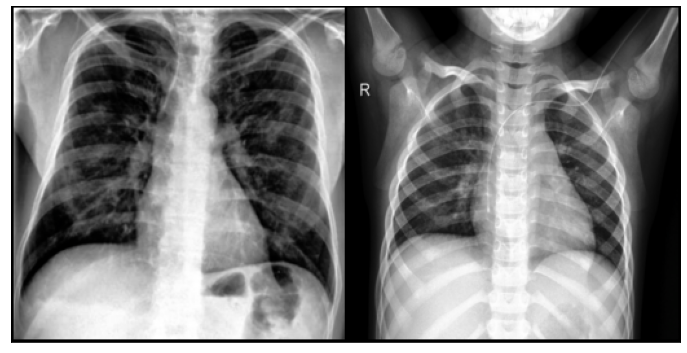

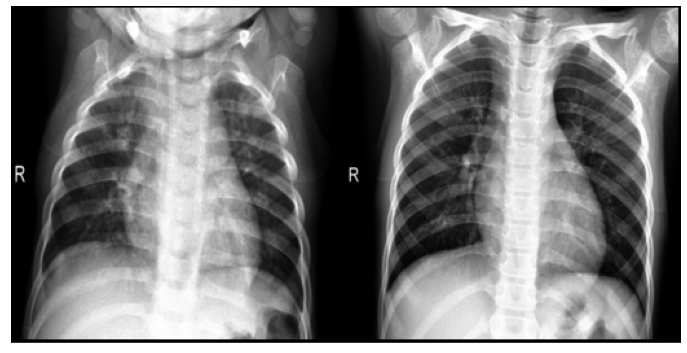

In [ ]:
show_grid(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Define Model

We will use resudial blocks in our network, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256, pool=True)
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.conv3 = conv_block(256, 512, pool=True)
        self.conv4 = conv_block(512, 1024, pool=True)
        self.res2 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=32),
                                        nn.MaxPool2d(2), 
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024*16*16, num_classes))
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 3), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

## Training the model

Before we train the model, we're going to make some improvements to our fit function like **Learning rate scheduling** which will use  **"One Cycle Learning Rate Policy"** strategy. We will also use **Weight decay and Gradient clipping** to help us in training process and will give a little boost in the accuracy.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.empty_cache()
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.3529411852359772, 'val_loss': 1.1030926704406738}]

In [ ]:
epochs = 8
max_lr = 0.02
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip = grad_clip,
                         weight_decay = weight_decay,
                         opt_func = opt_func)

Epoch [0], last_lr: 0.00786, train_loss: 98.1837, val_loss: 107.0177, val_acc: 0.6471
Epoch [1], last_lr: 0.01871, train_loss: 148.0143, val_loss: 128.0260, val_acc: 0.7794
Epoch [2], last_lr: 0.01944, train_loss: 82.7868, val_loss: 53.0867, val_acc: 0.7206
Epoch [3], last_lr: 0.01623, train_loss: 17.9043, val_loss: 33.5149, val_acc: 0.8088
Epoch [4], last_lr: 0.01112, train_loss: 4.9945, val_loss: 28.1592, val_acc: 0.8382
Epoch [5], last_lr: 0.00566, train_loss: 3.8941, val_loss: 16.2771, val_acc: 0.8676
Epoch [6], last_lr: 0.00153, train_loss: 1.0835, val_loss: 11.1660, val_acc: 0.8676
Epoch [7], last_lr: 0.00000, train_loss: 0.9706, val_loss: 12.7335, val_acc: 0.8824
CPU times: user 1min 44s, sys: 1min 26s, total: 3min 10s
Wall time: 3min 41s


## Plot the graphs

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

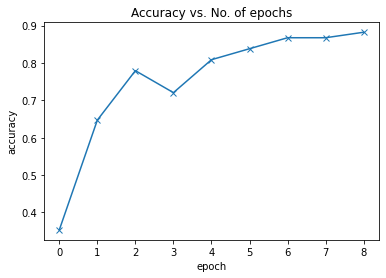

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx', label='Training')
  plt.plot(val_losses, '-rx', label='Validation')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title('Loss vs. No. of epochs');

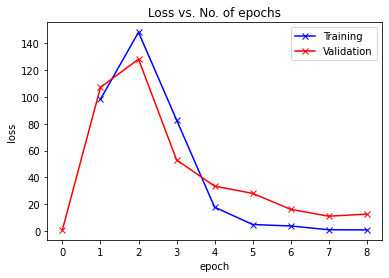

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

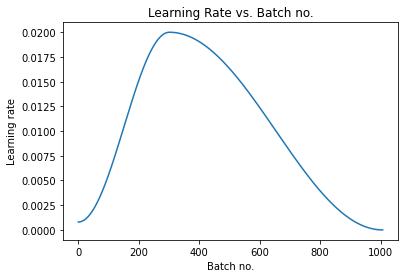

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value due to **"One Cycle Learning Rate Policy"**.

## Testing with individual images

In [ ]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return train_ds.classes[preds[0].item()]

In [ ]:
len(valid_ds)

66

Label: Covid , Predicted: Covid


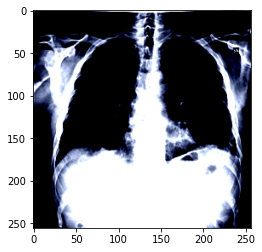

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Viral Pneumonia , Predicted: Normal


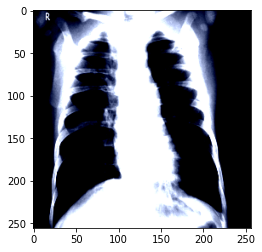

In [ ]:
img, label = valid_ds[65]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Normal , Predicted: Normal


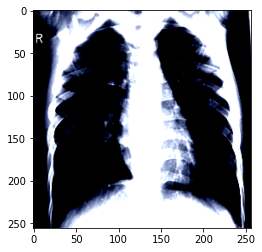

In [ ]:
img, label = valid_ds[45]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

## Save

In [ ]:
torch.save(model.state_dict(), 'covid-19-pneumonia-resnet9.pth')

## Summary and Further Reading

Here's a summary of the different techniques used in this notebook to improve our model performance and reduce the training time:


* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)

### Future work

This task can be further improved by adding feature for segmentation of infection areas in lungs for better detecting the disease etc.